In [46]:
import os
import biom
import warnings
import numpy as np
import pandas as pd
import qiime2 as q2
from skbio import DistanceMatrix
from biom import Table
from assets.util import add_taxsplit
from skbio import OrdinationResults
from qiime2.plugins.emperor.actions import biplot
import skbio
from skbio.stats.distance import MissingIDError


# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
#from upsetplot import UpSet
#from upsetplot import generate_counts, plot
#from upsetplot import from_memberships
#from matplotlib_venn import venn2
#from matplotlib_venn import (venn3, venn3_circles,venn2_circles)

# helper functions
from assets.util import (mantel_matched, simulate_depth, all_dists, nested_permanova)

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.style.use('ggplot')
plt.style.use('tableau-colorblind10')
paper_rc = {'lines.markersize': 5}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

%matplotlib inline



In [47]:
vector_df = q2.Artifact.load('./15000_shannon_matrix_val1_QE_HBM_R.qza').view(pd.Series)

In [48]:
md = q2.Metadata.load('./metadata_HBM_15000_matrix.tsv').to_dataframe()

In [49]:
md = md.loc[md.index.isin(vector_df.index)]

In [50]:
md = md.merge(vector_df, left_index=True, right_index=True)

In [51]:
md

,filename,ATTRIBUTE_locationcell,ATTRIBUTE_dna_conc,ATTRIBUTE_sample_type,ATTRIBUTE_sample_type2,ATTRIBUTE_host_life_stage,ATTRIBUTE_host_subject_id,ATTRIBUTE_pseudosample_id,replicate,ATTRIBUTE_storage_solution,ATTRIBUTE_host_body_mass_index,ATTRIBUTE_extraction_protocol,shannon_entropy
P3_A1.mzML,P3_A1.mzML,A1,6.448,feces,human_feces,adult,A,Plate 3 HBM_human_feces_A_Matrix1,1.0,etoh,not applicable,Matrix,5.589098
P3_A10.mzML,P3_A10.mzML,A10,32.106,feces,mouse_feces,adult,mouse1,Plate 3 HBM_mouse_feces_mouse1_Matrix1,1.0,isopropanol,not applicable,Matrix,6.169351
P3_A11.mzML,P3_A11.mzML,A11,6.507,feces,mouse_feces,adult,mouse2,Plate 3 HBM_mouse_feces_mouse2_Matrix1,1.0,isopropanol,not applicable,Matrix,6.194774
P3_A12.mzML,P3_A12.mzML,A12,3.158,feces,mouse_feces,adult,mouse3,Plate 3 HBM_mouse_feces_mouse3_Matrix1,1.0,isopropanol,not applicable,Matrix,6.033729
P3_A2.mzML,P3_A2.mzML,A2,1.285,saliva,human_saliva_before_brushing,adult,A,Plate 3 HBM_human_saliva_before_brushing_A_Mat...,1.0,etoh,not applicable,Matrix,6.010015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
P3_H5.mzML,P3_H5.mzML,H5,1.114,saliva,human_saliva_before_brushing,adult,C,Plate 3 HBM_human_saliva_before_brushing_C_Mat...,3.0,isopropanol,not applicable,Matrix,5.557002
P3_H6.mzML,P3_H6.mzML,H6,0.990,saliva,human_saliva_after_brushing,adult,C,Plate 3 HBM_human_saliva_after_brushing_C_Matrix3,3.0,isopropanol,not applicable,Matrix,5.905981
P3_H7.mzML,P3_H7.mzML,H7,2.002,saliva,human_saliva_before_brushing,adult,D,Plate 3 HBM_human_saliva_before_brushing_D_Mat...,3.0,etoh,not applicable,Matrix,6.085293
P3_H8.mzML,P3_H8.mzML,H8,0.767,saliva,human_saliva_after_brushing,adult,D,Plate 3 HBM_human_saliva_after_brushing_D_Matrix3,3.0,etoh,not applicable,Matrix,4.755884


In [52]:
def fancy_plotting(df):
    g = sns.relplot(data=df, x='etoh', y='isopropanol',
                    col='ATTRIBUTE_sample_type2',
                    col_order=['human_feces', 'mouse_feces', 'human_saliva_before_brushing', 'human_saliva_after_brushing'],
                    col_wrap=2,
                    kind='scatter')
    g.map_dataframe(sns.regplot, x='etoh', y='isopropanol')
    g.set_titles('{col_name}')
    return g

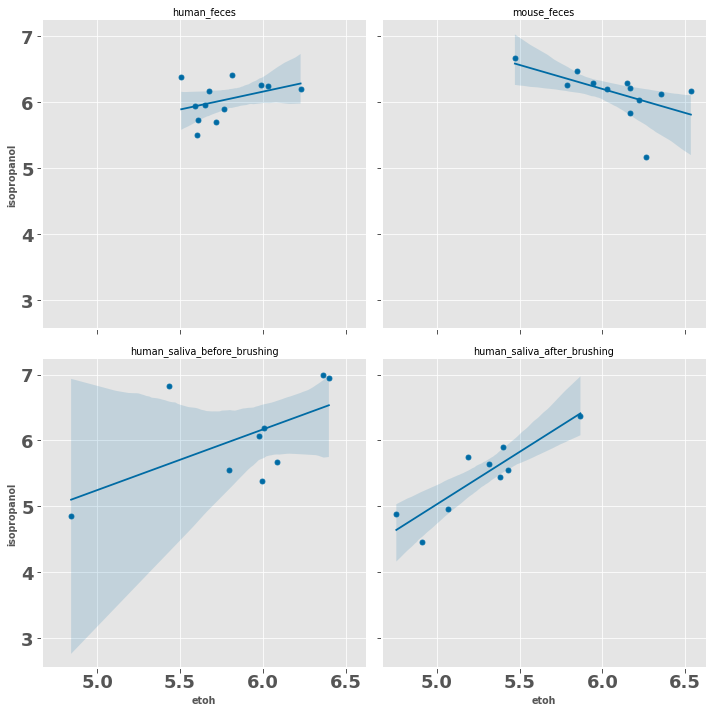

In [53]:
c = []
for loc, metadata in md.groupby('ATTRIBUTE_pseudosample_id'):
    if metadata.shape[0] == 2:
        c.append([loc,
                  metadata.loc[metadata['ATTRIBUTE_storage_solution'] == 'etoh', 'shannon_entropy'].values[0],
                  metadata.loc[metadata['ATTRIBUTE_storage_solution'] == 'isopropanol', 'shannon_entropy'].values[0],
                  metadata.loc[metadata['ATTRIBUTE_storage_solution'] == 'etoh', 'ATTRIBUTE_sample_type2'].values[0]])
fancy_plotting(pd.DataFrame(c, columns=['ATTRIBUTE_pseudosample_id', 'etoh', 'isopropanol', 'ATTRIBUTE_sample_type2']))

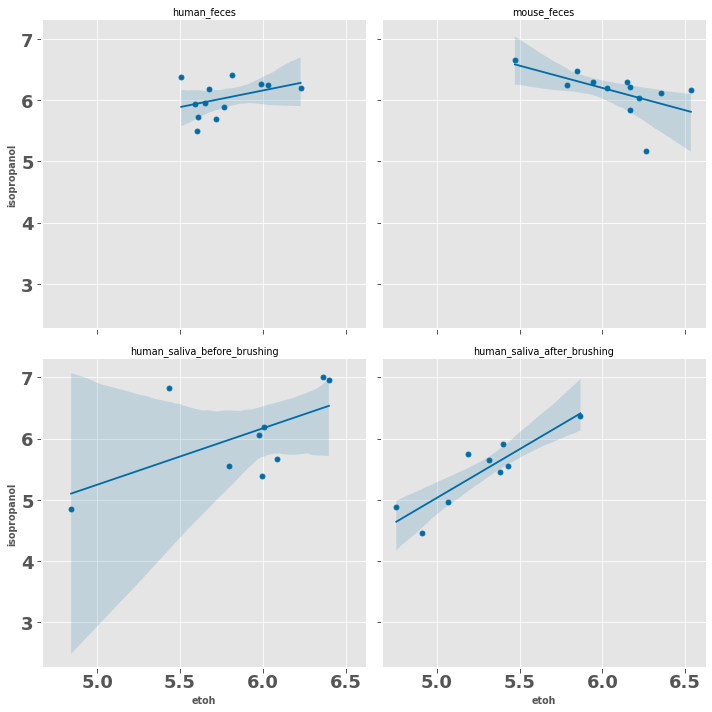

In [65]:
fancy_plotting(pd.DataFrame(c, columns=['ATTRIBUTE_pseudosample_id', 'etoh', 'isopropanol', 'ATTRIBUTE_sample_type2'])).savefig('./QE_shannon_entropy_storage_solution_scatter.png')

In [57]:
import scipy.stats as stats

In [58]:
md['shannon_entropy']

P3_A1.mzML     5.589098
P3_A10.mzML    6.169351
P3_A11.mzML    6.194774
P3_A12.mzML    6.033729
P3_A2.mzML     6.010015
                 ...   
P3_H5.mzML     5.557002
P3_H6.mzML     5.905981
P3_H7.mzML     6.085293
P3_H8.mzML     4.755884
P3_H9.mzML     6.146173
Name: shannon_entropy, Length: 84, dtype: float64

In [59]:
md.etoh=md[md.ATTRIBUTE_storage_solution == 'etoh']
md.ipa=md[md.ATTRIBUTE_storage_solution == 'isopropanol']
md.etoh.shannon=md.etoh['shannon_entropy']
md.ipa.shannon=md.ipa['shannon_entropy']

md.etoh.mouse=md.etoh[md.etoh.ATTRIBUTE_sample_type2 == 'mouse_feces']
md.etoh.mouse.shannon=md.etoh.mouse['shannon_entropy']
md.ipa.mouse=md.ipa[md.ipa.ATTRIBUTE_sample_type2 == 'mouse_feces']
md.ipa.mouse.shannon=md.ipa.mouse['shannon_entropy']

md.etoh.human=md.etoh[md.etoh.ATTRIBUTE_sample_type2 == 'human_feces']
md.etoh.human.shannon=md.etoh.human['shannon_entropy']
md.ipa.human=md.ipa[md.ipa.ATTRIBUTE_sample_type2 == 'human_feces']
md.ipa.human.shannon=md.ipa.human['shannon_entropy']

md.etoh.saliva_b=md.etoh[md.etoh.ATTRIBUTE_sample_type2 == 'human_saliva_before_brushing']
md.etoh.saliva_b.shannon=md.etoh.saliva_b['shannon_entropy']
md.ipa.saliva_b=md.ipa[md.ipa.ATTRIBUTE_sample_type2 == 'human_saliva_before_brushing']
md.ipa.saliva_b.shannon=md.ipa.saliva_b['shannon_entropy']

md.etoh.saliva_a=md.etoh[md.etoh.ATTRIBUTE_sample_type2 == 'human_saliva_after_brushing']
md.etoh.saliva_a.shannon=md.etoh.saliva_a['shannon_entropy']
md.ipa.saliva_a=md.ipa[md.ipa.ATTRIBUTE_sample_type2 == 'human_saliva_after_brushing']
md.ipa.saliva_a.shannon=md.ipa.saliva_a['shannon_entropy']

In [60]:
stats.wilcoxon(md.etoh.shannon,md.ipa.shannon)



WilcoxonResult(statistic=303.0, pvalue=0.06382007480306129)

In [61]:
stats.wilcoxon(md.ipa.mouse.shannon,md.etoh.mouse.shannon)

WilcoxonResult(statistic=19.0, pvalue=0.12939453125)

In [62]:
stats.wilcoxon(md.ipa.human.shannon,md.etoh.human.shannon)

WilcoxonResult(statistic=10.0, pvalue=0.02099609375)

In [63]:
stats.wilcoxon(md.ipa.saliva_b.shannon,md.etoh.saliva_b.shannon)

WilcoxonResult(statistic=18.0, pvalue=0.65234375)

In [64]:
stats.wilcoxon(md.ipa.saliva_a.shannon,md.etoh.saliva_a.shannon)

WilcoxonResult(statistic=15.0, pvalue=0.42578125)